In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
df = pd.read_csv('dailygroundnut.csv')

In [3]:
df


,Unnamed: 0,Datetime,AvgPrice
0,0,01-01-2011,3166.0
1,1,02-01-2011,2380.0
2,2,03-01-2011,4083.0
3,3,04-01-2011,4100.0
4,4,05-01-2011,4074.0
...,...,...,...
3602,3602,21-02-2024,8070.0
3603,3603,22-02-2024,8000.0
3604,3604,23-02-2024,8015.0
3605,3605,24-02-2024,6940.0


In [4]:
df.columns

Index(['Unnamed: 0', 'Datetime', 'AvgPrice'], dtype='object')

In [5]:
df = df = df[['AvgPrice', 'Datetime']]

In [6]:
df.head()

,AvgPrice,Datetime
0,3166.0,01-01-2011
1,2380.0,02-01-2011
2,4083.0,03-01-2011
3,4100.0,04-01-2011
4,4074.0,05-01-2011


In [7]:
df.head()

,AvgPrice,Datetime
0,3166.0,01-01-2011
1,2380.0,02-01-2011
2,4083.0,03-01-2011
3,4100.0,04-01-2011
4,4074.0,05-01-2011


In [8]:
df_sorted = df.copy()
df_sorted.sort_values(by='Datetime', inplace=True)

In [9]:
df.update(df_sorted)

In [10]:
df.head()

,AvgPrice,Datetime
0,3166.0,01-01-2011
1,2380.0,02-01-2011
2,4083.0,03-01-2011
3,4100.0,04-01-2011
4,4074.0,05-01-2011


In [11]:
# Convert 'datetime' column to datetime datatype
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y')

# Set 'datetime' as index
df.set_index('Datetime', inplace=True)

C:\Users\Suliyaa Mantaw\AppData\Local\Temp\ipykernel_15096\2395552005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y')


In [12]:
df.head()

,AvgPrice
Datetime,
2011-01-01,3166.0
2011-01-02,2380.0
2011-01-03,4083.0
2011-01-04,4100.0
2011-01-05,4074.0


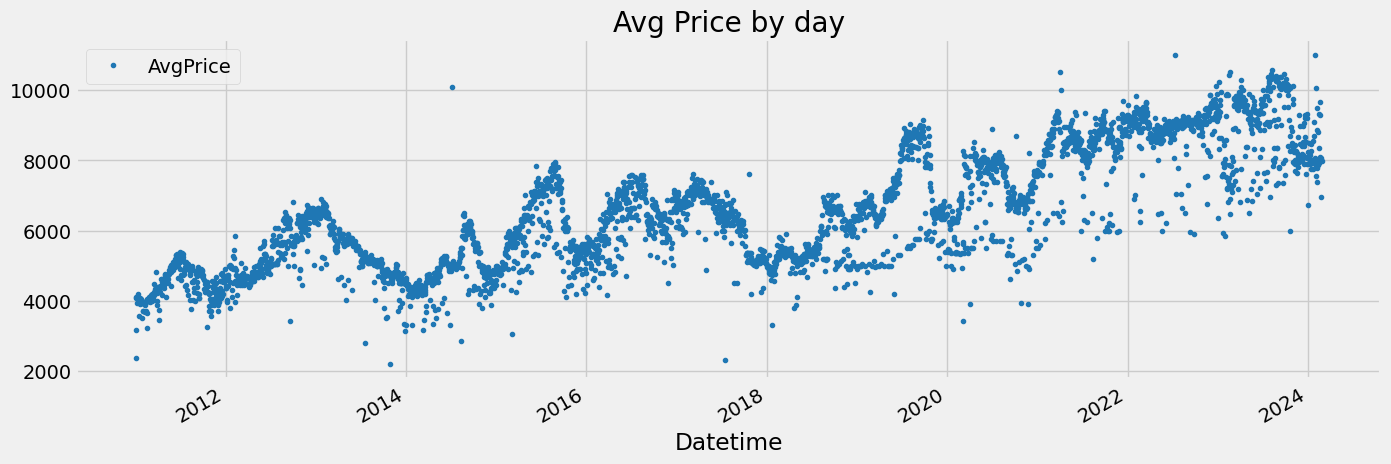

In [13]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Avg Price by day')
plt.show()

In [14]:
# 1 Outlier Analysis and removal

<Axes: ylabel='Frequency'>

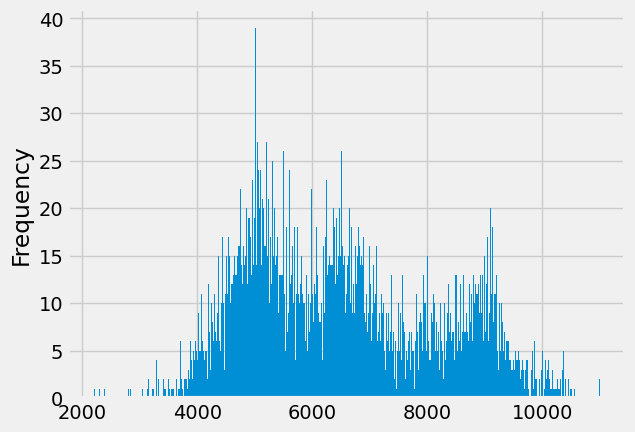

In [15]:
df['AvgPrice'].plot(kind='hist', bins=500)

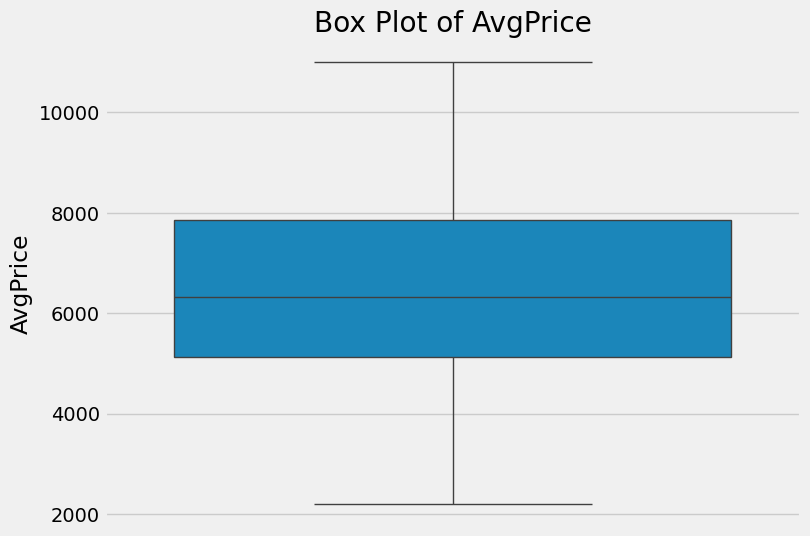

In [16]:
# Method 1: Box Plot for 'AvgPrice'
plt.figure(figsize=(8, 6))
sns.boxplot(data=df['AvgPrice'])
plt.title('Box Plot of AvgPrice')
plt.show()

In [17]:
# boxplot shows no outliers

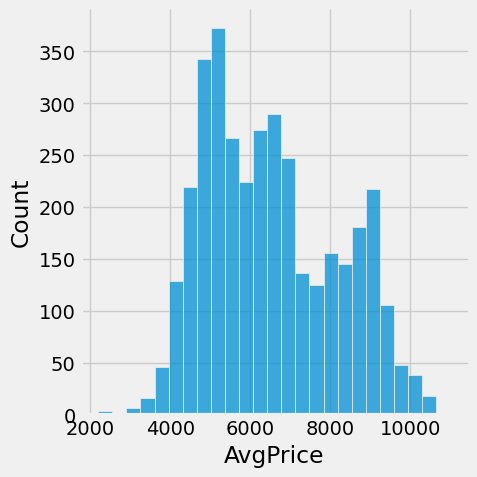

In [18]:
sns.displot(df['AvgPrice']); # distribution plot

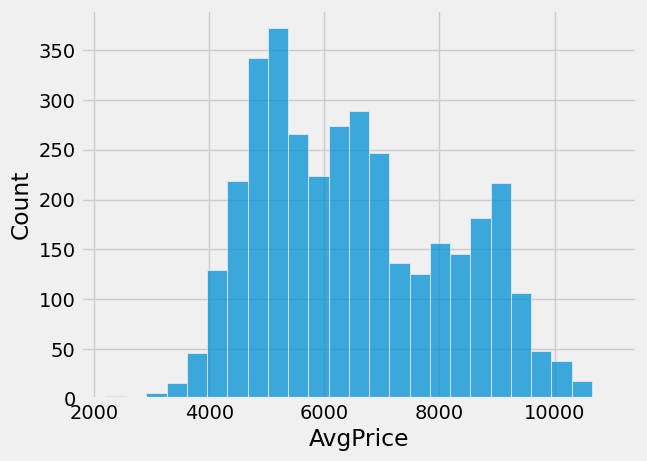

In [19]:
sns.histplot(df['AvgPrice']);

In [20]:
print("skewness: %f" % df['AvgPrice'].skew()) #calculating Skewness
print("Kurtosis: %f" % df['AvgPrice'].kurt()) #calculating Kurtosis

skewness: 0.375772
Kurtosis: -0.840585


In [21]:
df.head()

,AvgPrice
Datetime,
2011-01-01,3166.0
2011-01-02,2380.0
2011-01-03,4083.0
2011-01-04,4100.0
2011-01-05,4074.0


In [22]:
df.tail()

,AvgPrice
Datetime,
2024-02-21,8070.0
2024-02-22,8000.0
2024-02-23,8015.0
2024-02-24,6940.0
2024-02-26,7975.0


In [23]:
import datetime

# Define the start and end dates
start_date = datetime.date(2010, 1, 4)
end_date = datetime.date(2024, 2, 26)

# Calculate the total number of days
total_days = (end_date - start_date).days

# Calculate the number of days for training (80%)
train_days = int(total_days * 0.8)

# Calculate the split date by adding the number of training days to the start date
split_date = start_date + datetime.timedelta(days=train_days)

print("Split date for 80:20 train-test split:", split_date)

Split date for 80:20 train-test split: 2021-04-28


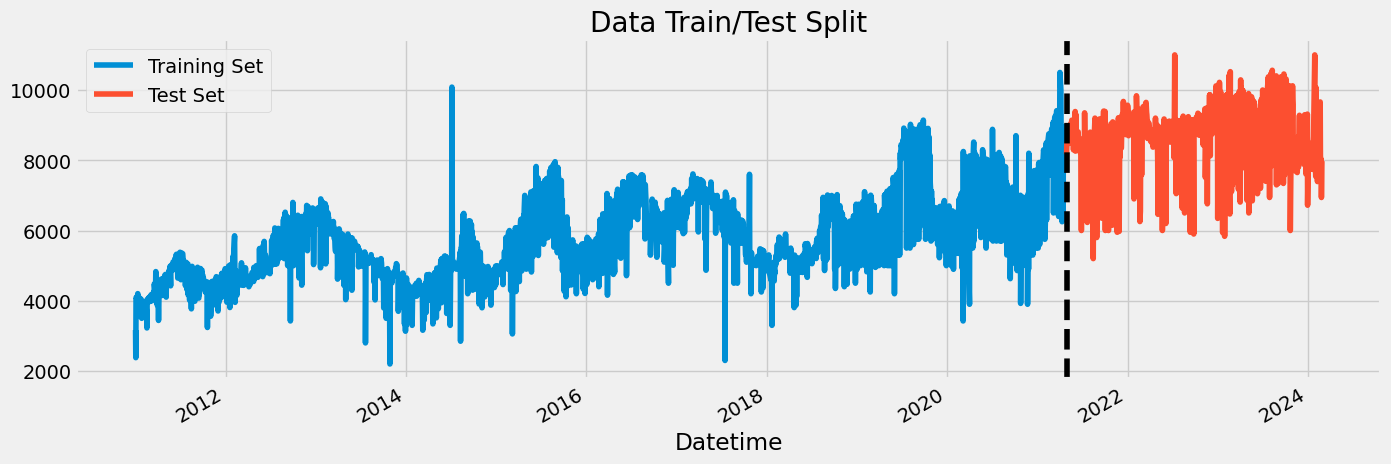

In [24]:
train = df.loc[df.index < '2021-04-28']
test = df.loc[df.index >= '2021-04-28']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2021-04-28', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

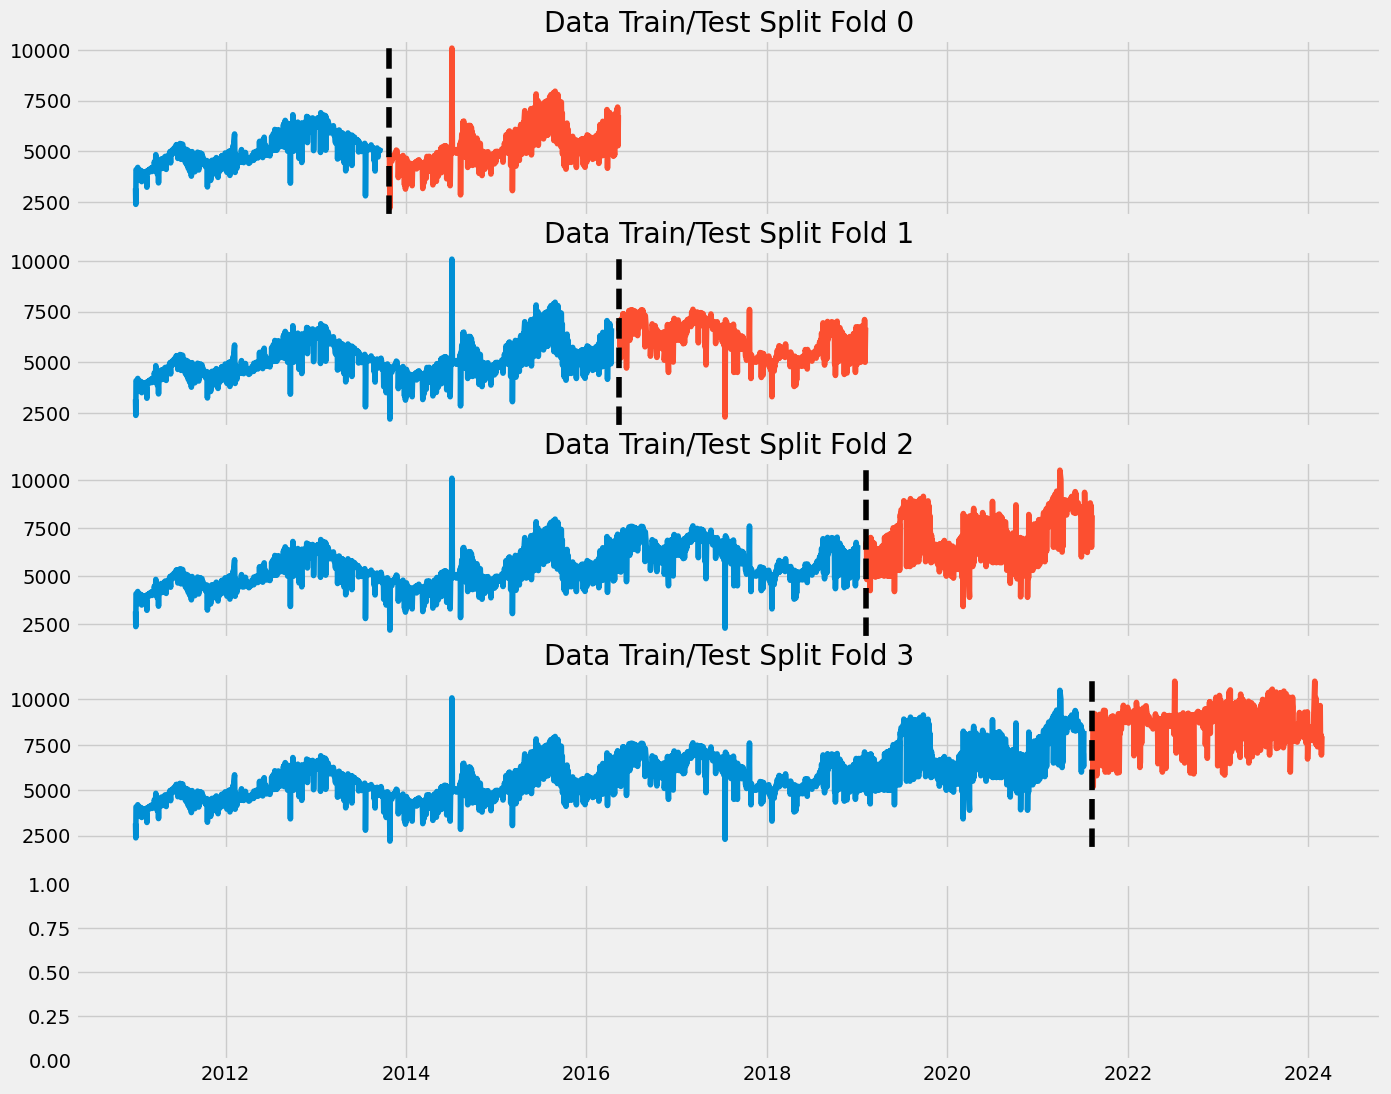

In [25]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

tss = TimeSeriesSplit(n_splits=4, test_size=24*30*1, gap=24)
df = df.sort_index()  # Assuming df is your DataFrame

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['AvgPrice'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['AvgPrice'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


In [26]:
def create_features(df):
    """
    Create time series features based on time series index within the specified test size.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    # Ensure that 'weekofyear' is computed within the test window
    df['weekofyear'] = (df.index - df.index[0]).days // 7 + 1  # Compute week of the year relative to the start of the data
    return df

df = create_features(df)

In [27]:
def add_lags(df):
    """
    Add lag features to the DataFrame based on the specified lag offsets.
    """
    target_map = df['AvgPrice'].to_dict()
    lag_offsets = [30 * i for i in range(1, 4)]  # Lag offsets in days: 30, 60, 90 (for 1, 2, 3 months)
    for lag, offset in enumerate(lag_offsets, start=1):
        df[f'lag{lag}'] = df.index - pd.Timedelta(days=offset)
        df[f'lag{lag}'] = df[f'lag{lag}'].map(target_map)
    return df


In [28]:
df = add_lags(df)

In [29]:
# training using cross validation

In [30]:
df.head()

,AvgPrice,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,
2011-01-01,3166.0,5,1,1,2011,1,1,1,NaN,NaN,NaN
2011-01-02,2380.0,6,1,1,2011,2,2,1,NaN,NaN,NaN
2011-01-03,4083.0,0,1,1,2011,3,3,1,NaN,NaN,NaN
2011-01-04,4100.0,1,1,1,2011,4,4,1,NaN,NaN,NaN
2011-01-05,4074.0,2,1,1,2011,5,5,1,NaN,NaN,NaN


In [31]:
tss = TimeSeriesSplit(n_splits=4, test_size=24*30*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear',  'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'AvgPrice'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:5092.23894	validation_1-rmse:5463.53673
[100]	validation_0-rmse:1927.33817	validation_1-rmse:2183.61609
[200]	validation_0-rmse:800.05282	validation_1-rmse:1203.04126
[300]	validation_0-rmse:445.35083	validation_1-rmse:984.61452
[400]	validation_0-rmse:352.29259	validation_1-rmse:942.59933
[500]	validation_0-rmse:329.14541	validation_1-rmse:934.38056
[600]	validation_0-rmse:317.98402	validation_1-rmse:933.12438
[614]	validation_0-rmse:316.54279	validation_1-rmse:933.10127
[0]	validation_0-rmse:5253.83269	validation_1-rmse:6059.82118
[100]	validation_0-rmse:2007.34613	validation_1-rmse:2366.05913
[200]	validation_0-rmse:875.29654	validation_1-rmse:1092.69726
[300]	validation_0-rmse:530.79668	validation_1-rmse:765.67302
[400]	validation_0-rmse:435.18085	validation_1-rmse:732.14477
[424]	validation_0-rmse:424.92079	validation_1-rmse:733.57495
[0]	validation_0-rmse:5538.39397	validation_1-rmse:7306.06185
[100]	validation_0-rmse:2114.17555	validation_1-rmse:3515.43093


In [32]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1091.8429
Fold scores:[932.186602868767, 731.1007053296345, 1439.1000751586841, 1264.9841819835854]


In [33]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'AvgPrice'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:6657.86108
[100]	validation_0-rmse:2542.71564
[200]	validation_0-rmse:1137.80147
[300]	validation_0-rmse:739.57253
[400]	validation_0-rmse:648.96309
[499]	validation_0-rmse:622.17658


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
df.index.max()

Timestamp('2024-02-26 00:00:00')

In [35]:
future = pd.date_range('2024-02-26','2026-03-26', freq='24h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [36]:
future_w_features = df_and_future.query('isFuture').copy()

In [37]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

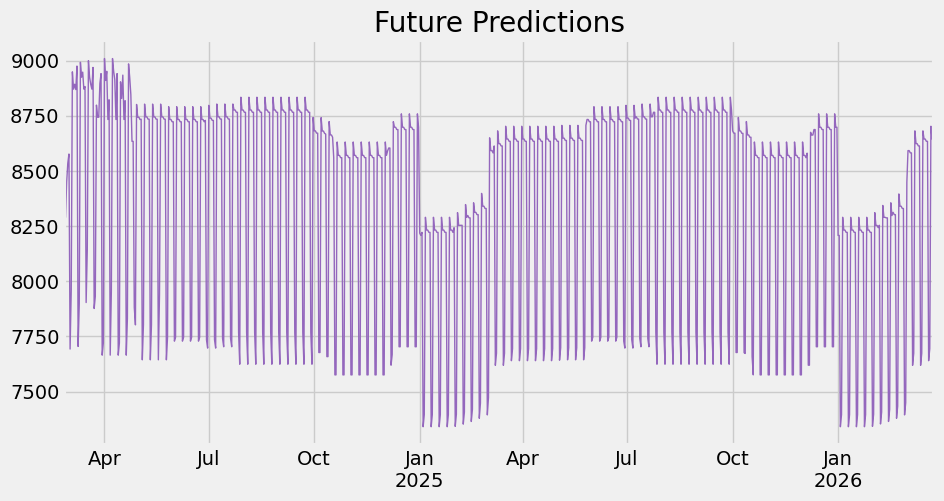

In [38]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

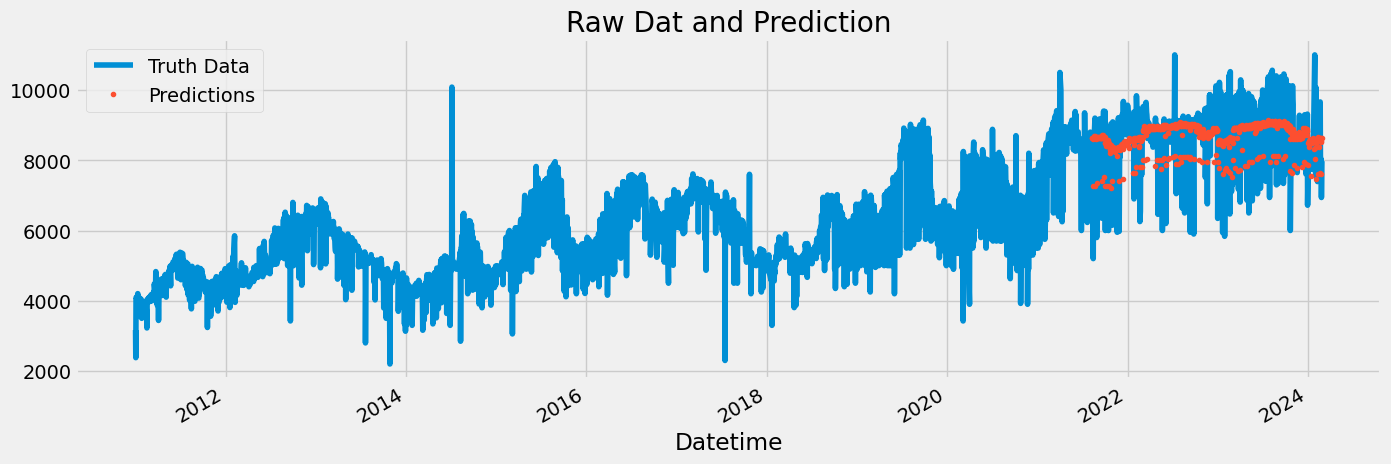

In [39]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['AvgPrice']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [40]:
score = np.sqrt(mean_squared_error(test['AvgPrice'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 791.82


In [41]:
def calculate_mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE).
    
    Parameters:
        y_true (array-like): Array of true values.
        y_pred (array-like): Array of predicted values.
        
    Returns:
        float: MAPE value.
    """
    assert len(y_true) == len(y_pred), "Lengths of true and predicted values must be equal."
    n = len(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

# Calculate MAPE
mape = calculate_mape(test['AvgPrice'], test['prediction'])
print(f'MAPE Score on Test set: {mape:0.2f}%')

MAPE Score on Test set: 7.16%


In [42]:
# Assuming you have already generated predictions for future dates and stored them in 'future_w_features' DataFrame

# Step 1: Extract relevant columns (date and predictions)
predictions_df = future_w_features[['pred']]

# Step 2: Save predictions to a CSV file
predictions_df.to_csv('NGround_pred.csv')

In [43]:
reg.save_model('Price_pred_coco.json')